## Setup
#### Import libraries

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy.sparse as ssp
import pandas as pd
import os
import matplotlib.pyplot as plt
import scrublet as scr
import scanpy as sc
import time

# !!!!
# Change this path to point to folder containing helper_functions.py
sys.path.append('./')
import helper_functions as hf

#### Set up display parameters for nicer looking plots

In [2]:
hf.set_plot_defaults(fontsize=12)

## Load raw data
#### Specify metadata and path to raw data


In [2]:
input_paths = {
    'example_data': ['1-1', '2-1', '1-2', '2-2', '3-1', '3-2']
}

h5ad_dir = 'h5ad_files'
plot_dir = '_plots'

# `meta_keys` lists the names of the columns to be added to the .obs dataframe.
# For each key in `meta_keys`, there must be a corresponding entry in the 
# `meta_values` list for each sample.
# Use key 'new name' if you want to convert the original sample IDs into more
# meaningful sample names.
meta_keys = ['new name', 'timepoint', 'batch']
meta_values = {
    '1-1':   ['ctrl-d10-1', '10day', 1],
    '2-1':   ['ctrl-d10-2', '10day', 2],
    '1-2':   ['ctrl-d30-1', '30day', 1],
    '2-2':   ['ctrl-d30-2', '30day', 2],
    '3-1':   ['ctrl-d120-1', '120day', 3],
    '3-2':   ['ctrl-d120-2', '120day', 3]
}

# Set some default filtering parameters. These can be
# customized for each library at a later step.

# min number of UMIs per cell barcode, for separating 
# background from real cells
default_min_tot = 500  

# max fraction of UMIs from mitochondrial genes, for 
# separating live and dead cells
default_max_mito_frac = 0.15 


#### Load raw counts matrices from indrops.py pipeline (.tsv files), saving .h5ad files for faster loading in the future

In [3]:
######

sample_list = []
D = {}
os.makedirs(h5ad_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

for iFold, folder in enumerate(input_paths):
    for orig_name in input_paths[folder]:
        meta_dict = {k: meta_values[orig_name][i] for i,k in enumerate(meta_keys)}
        
        if 'new name' in meta_keys:
            new_name = meta_dict['new name']
        else:
            new_name = orig_name    
        sample_list.append(new_name)
        
        h5ad_filename = f'{h5ad_dir}/{new_name}-raw.h5ad'
        if os.path.exists(h5ad_filename):
            D[new_name] = sc.read(h5ad_filename)
        else:
            X, barcodes, genes = hf.load_annotated_text(
                hf.file_opener(f'{folder}/{orig_name}.counts.tsv.gz'),
                delim='\t',
                read_row_labels=True,
                read_column_labels=True
            )
            D[new_name] = sc.AnnData(X)
            D[new_name].obs_names = barcodes
            D[new_name].var_names = genes
            D[new_name].var_names_make_unique()
            del X, barcodes, genes
                        
            D[new_name].uns['min_tot'] = default_min_tot
            D[new_name].uns['max_mito'] = default_max_mito_frac
            
            for k,v in meta_dict.items():
                if k != 'new name':
                    D[new_name].obs[k] = v
                    
            D[new_name].write_h5ad(h5ad_filename, compression='gzip', force_dense=False)

        print('Loaded {}: {} barcodes, {} genes'.format(new_name, *D[new_name].shape))

... storing 'timepoint' as categorical


Loaded ctrl-d10-1: 3235 barcodes, 40523 genes


... storing 'timepoint' as categorical


Loaded ctrl-d10-2: 5181 barcodes, 40523 genes


... storing 'timepoint' as categorical


Loaded ctrl-d30-1: 3481 barcodes, 40523 genes


... storing 'timepoint' as categorical


Loaded ctrl-d30-2: 3058 barcodes, 40523 genes


... storing 'timepoint' as categorical


Loaded ctrl-d120-1: 4650 barcodes, 40523 genes


... storing 'timepoint' as categorical


Loaded ctrl-d120-2: 3922 barcodes, 40523 genes


Since all samples have identical gene lists, let's create a more accessible gene list variable.

In [20]:
gene_list = D[new_name].var_names.values.astype(str)

## Filter out background based on UMIs/cell
#### First, plot histograms and customize filtering thresholds
No filtering is actually done here, just checking that the total UMIs threshold is appropriate for each library. The threshold should lie between the two modes of the histogram, where the left mode corresponds to background and the right to real cells. Also check that (roughly) the expected number of cells are passing the filter.

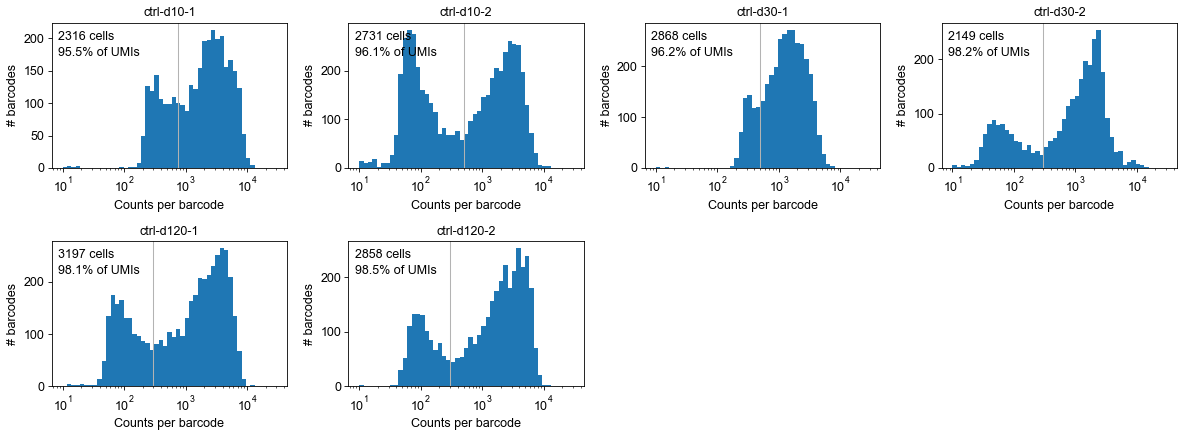

In [16]:
saving = True

# Change total count thresholds based on the histograms. 
# If a library is not included below, the default threshold is used.
D['ctrl-d10-1'].uns['min_tot'] = 750
D['ctrl-d30-2'].uns['min_tot'] = 300
D['ctrl-d120-1'].uns['min_tot'] = 300
D['ctrl-d120-2'].uns['min_tot'] = 300

############

# Start figure
fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=3, n_columns=4, fig_width=16, dpi=75)

for iS,s in enumerate(sample_list):
    # Loop over each library, plotting histogram of total counts (UMIs) per cell
    
    # Set subplot
    ax = plt.subplot(nrow, ncol, iS+1)
    
    # Calculate total counts per cells (row sums of counts matrix)
    D[s].obs['n_counts'] = D[s].X.sum(1).A.squeeze()
    
    # Get minimum total counts threshold. Barcodes with 
    # total counts >= min_tot are considered real cells. 
    min_tot = D[s].uns['min_tot']
    
    # Plot the histogram
    hf.total_counts_histogram(D[s].obs['n_counts'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=False)
    ax.set_title(s, fontsize=12)
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    
    # Plot the threshold    
    ax.plot(min_tot * np.ones(2), yl, c=.7*np.ones(3), linewidth=1)
    
    # Calculate number of barcodes and pct of UMIs passing filter and show on plot
    mask = D[s].obs['n_counts'].values >= min_tot
    ntot = D[s].shape[0]
    npass = mask.sum()
    umitot = D[s].obs['n_counts'].values.sum()
    umipass = D[s].obs['n_counts'].values[mask].sum()
    
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.88, '{} cells'.format(npass), fontsize=12)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.77, '{:.1f}% of UMIs'.format(umipass/umitot*100), fontsize=12)
    
fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/background_filtering.pdf')


#### Now actually remove barcodes with too few UMIs

In [18]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_list:
    keep = D[s].obs['n_counts'] >= D[s].uns['min_tot']
    D[s] = D[s][keep]
    
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))
    

Sample                  # barcodes pre-filter   # barcodes post-filter
ctrl-d10-1                               3235                     2316
ctrl-d10-2                               5181                     2731
ctrl-d30-1                               3481                     2868
ctrl-d30-2                               3058                     2149
ctrl-d120-1                              4650                     3197
ctrl-d120-2                              3922                     2858


## Filter out dead cells based on mitochondrial gene fraction
#### Find mitochondrial genes (for mouse: all genes starting with "mt-")

In [23]:
mt_ix = np.array([i for i,g in enumerate(gene_list) if (g.startswith('mt-') or g.startswith('MT-'))], dtype=int)
print(gene_list[mt_ix])

['mt-Atp6' 'mt-Atp8' 'mt-Co1' 'mt-Co2' 'mt-Co3' 'mt-Cytb' 'mt-Nd1'
 'mt-Nd2' 'mt-Nd3' 'mt-Nd4' 'mt-Nd4l' 'mt-Nd5' 'mt-Nd6' 'mt-Rnr1'
 'mt-Rnr2' 'mt-Ta' 'mt-Tc' 'mt-Td' 'mt-Te' 'mt-Tf' 'mt-Tg' 'mt-Th' 'mt-Ti'
 'mt-Tk' 'mt-Tl1' 'mt-Tl2' 'mt-Tm' 'mt-Tn' 'mt-Tp' 'mt-Tq' 'mt-Tr'
 'mt-Ts1' 'mt-Ts2' 'mt-Tt' 'mt-Tv' 'mt-Tw' 'mt-Ty']


#### First, plot histograms and customize filtering thresholds
As above, no filtering is actually done in this first step, just checking that the threshold doesn't need to be adjusted. Healthy samples usually have >90% of cells passing the filter (e.g., <20% mitochondrial gene counts).

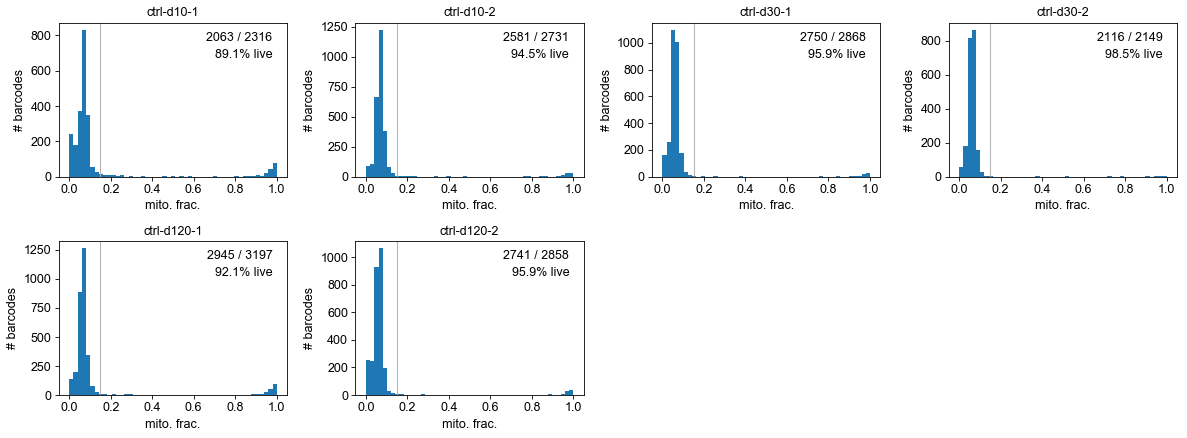

In [30]:
saving=True

# Start figure
fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=3, n_columns=4, fig_width=16, dpi=75)

for iS,s in enumerate(sample_list):
    # Loop over each library, plotting histogram of fraction of UMIs
    # coming from mitochondrial genes.
    
    max_mt = D[s].uns['max_mito']
    
    # Set subplot
    ax = plt.subplot(nrow, ncol, iS+1)

    # Calculate fraction of counts from mitochondrial  genes
    D[s].obs['mito_frac'] = D[s].X[:,mt_ix].sum(1).A.squeeze() / D[s].obs['n_counts'].values
    
    # Plot the histogram
    ax.hist(D[s].obs['mito_frac'], np.linspace(0, 1, 50));
    ax.set_title(s, fontsize=12)
    ax.set_xlabel('mito. frac.')
    ax.set_ylabel('# barcodes')
    
    xl = np.array([0,1])
    yl = np.array(ax.get_ylim())
    ax.set_ylim(xl)
    ax.set_ylim(yl)
    
    # Plot the threshold    
    ax.plot(max_mt * np.ones(2), yl, c=.7*np.ones(3), linewidth=1)
    
    # Calculate number of barcodes passing filter and show on plot
    ntot = len(D[s].obs['mito_frac'])
    npass = (D[s].obs['mito_frac'] <= max_mt).sum()
    ax.text(
        xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.88, 
        '{} / {}'.format(npass, ntot), fontsize=12, ha='right')
    ax.text(
        xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.77, 
        '{:.1f}% live'.format(npass/ntot*100), fontsize=12, ha='right')
    
fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/dead_cell_filtering.pdf')

#### Now actually remove barcodes with too many mitochondrial gene counts

In [32]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_list:
    max_mt = D[s].uns['max_mito']
    keep = D[s].obs['mito_frac'] <= max_mt
    D[s] = D[s][keep]
    
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))


Sample                  # barcodes pre-filter   # barcodes post-filter
ctrl-d10-1                               2316                     2063
ctrl-d10-2                               2731                     2581
ctrl-d30-1                               2868                     2750
ctrl-d30-2                               2149                     2116
ctrl-d120-1                              3197                     2945
ctrl-d120-2                              2858                     2741


## Summary stats

In [36]:
print('{:20s}{:>5s}{:>16s}{:>16s}{:>16s}{:>16s}'.format(
    'Library', 'N', 'Mean UMI', 'Median UMI', 'Mean Genes', 'Median Genes'))

for s in sample_list:
    tc = D[s].obs['n_counts'].values
    tg = (D[s].X>0).sum(1).A.squeeze()
    print(f'{s:20s}{D[s].shape[0]:5}{np.mean(tc):16.0f}{np.median(tc):16.0f}{np.mean(tg):16.0f}{np.median(tg):16.0f}')

Library                 N        Mean UMI      Median UMI      Mean Genes    Median Genes
ctrl-d10-1           2063            3620            3080            1556            1453
ctrl-d10-2           2581            2740            2415            1341            1285
ctrl-d30-1           2750            1875            1590            1011             916
ctrl-d30-2           2116            1940            1677             983             926
ctrl-d120-1          2945            2861            2489            1342            1297
ctrl-d120-2          2741            3049            2611            1381            1333


## Save filtered data to h5ad files

In [39]:
for s in sample_list:
    D[s].write_h5ad(f'{h5ad_dir}/{s}-filtered.h5ad', compression='gzip', force_dense=False)

In [44]:
# To load the filtered files at a later point:
sample_list = ['ctrl-d10-1', 'ctrl-d10-2', 'ctrl-d30-1', 'ctrl-d30-2', 'ctrl-d120-1', 'ctrl-d120-2']
h5ad_dir = 'h5ad_files'
D = {}
for s in sample_list:
    D[s] = sc.read(f'{h5ad_dir}/{s}-filtered.h5ad')
gene_list = D[s].var_names.values.astype(str)

# Merged analysis

### Merge filtered data from all libraries


In [52]:
samps_merge = sample_list
print('Merging', samps_merge)

adata = sc.AnnData.concatenate(
    *[D[s] for s in samps_merge], 
    batch_key='sample',
    batch_categories=samps_merge
)

adata.raw = adata



Merging ['ctrl-d10-1', 'ctrl-d10-2', 'ctrl-d30-1', 'ctrl-d30-2', 'ctrl-d120-1', 'ctrl-d120-2']


In [53]:
adata

AnnData object with n_obs × n_vars = 15196 × 40523 
    obs: 'batch', 'mito_frac', 'n_counts', 'sample', 'timepoint'

#### Total counts normalization
Helps remove technical variation between cells

In [56]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=adata.obs['n_counts'].mean())

#### Identify highly variable genes
Keep genes with at least `min_counts` counts in at least `min_cells` cells and in the most variable `min_vscore_pctl` percentile of genes

Finding highly variable genes...


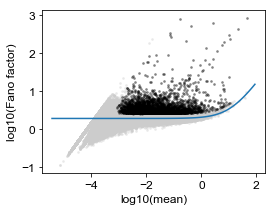

Keeping 2985 genes


In [60]:
min_counts = 3
min_cells = 3
min_vscore_pctl = 85

print('Finding highly variable genes...')
highvar_genes = gene_list[hf.filter_genes(
    adata.X, 
    min_counts=min_counts, 
    min_cells=min_cells, 
    min_vscore_pctl=min_vscore_pctl, 
    show_vscore_plot=True)]

adata.var['highly_variable'] = False
adata.var.loc[highvar_genes, 'highly_variable'] = True

print(f'Keeping {len(highvar_genes)} genes')

#### Run PCA on cells using highly variable genes
By default, `hf.get_pca()` automatically scales the data (z-score) at the gene level before running PCA.


In [65]:
# Number of principal components
n_pcs = 40

adata.obsm['X_pca'] = hf.get_pca(adata[:, highvar_genes].X, numpc=n_pcs)


#### Build k-nearest neighbor graph
This will be used for clustering, UMAP, SPRING

In [69]:
# Number of neighbors for KNN graph construction
n_neighbors = 10

sc.pp.neighbors(adata, n_neighbors=n_neighbors)

#### Cluster cells (Leiden clustering)

In [71]:
sc.tl.leiden(adata, resolution=1)

#### Get 2-D embedding using UMAP

In [72]:
# UMAP parameters
umap_min_dist = 0.3

sc.tl.umap(adata, min_dist=umap_min_dist)

#### Run Scrublet

In [87]:
scrub = scr.Scrublet(adata.raw.X, expected_doublet_rate=0.06)
adata.obs['doublet_score'], adata.obs['predicted_doublet'] = scrub.scrub_doublets(
    min_cells=min_cells, 
    min_counts=min_counts, 
    min_gene_variability_pctl=min_vscore_pctl,
    n_prin_comps=n_pcs
)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 32.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.1%
Elapsed time: 18.3 seconds


Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 42.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.5%


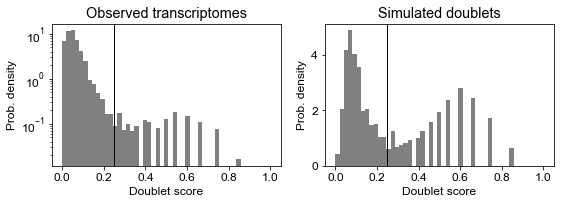

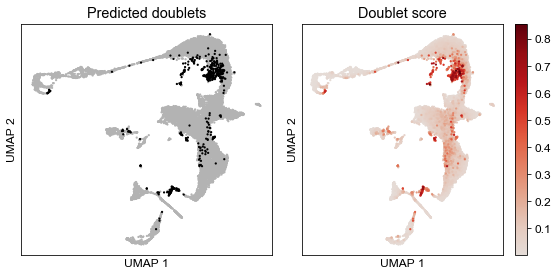

In [89]:
adata.obs['predicted_doublet'] = scrub.call_doublets(threshold=0.25)

scrub.plot_histogram();
scrub.set_embedding('UMAP', adata.obsm['X_umap'])
scrub.plot_embedding('UMAP', order_points=True);

### save the processed data

In [90]:
adata.write_h5ad(f'{h5ad_dir}/merged.h5ad', compression='gzip', force_dense=False)

... storing 'timepoint' as categorical


In [3]:
# To load the filtered files at a later point:
h5ad_dir = 'h5ad_files'
adata = sc.read(f'{h5ad_dir}/merged.h5ad')
gene_list = adata.var_names.values.astype(str)

## Visualize using 2-D embedding (UMAP)


In [7]:
x = adata.obsm['X_umap'][:,0]
y = adata.obsm['X_umap'][:,1]

#### Check out where each sample's cells lie in the embedding
In each subplot, cells from one sample are colored black, and all others are gray.  
Because this example notebook only includes control cells, they should all mostly overlap.

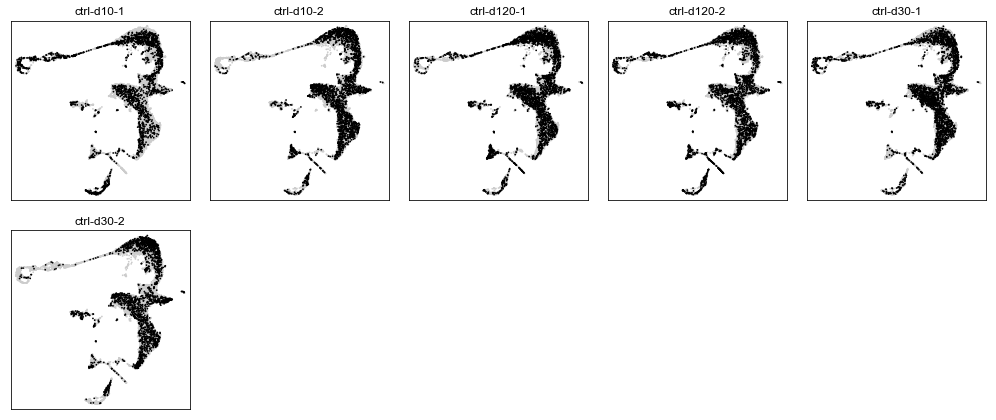

In [8]:
hf.plot_groups(x, y, adata.obs['sample'].values.astype(str))

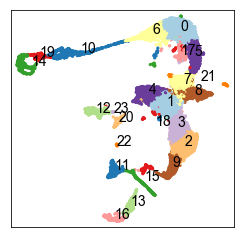

In [93]:
hf.plot_categorical(x, y, adata.obs['leiden'].values, show_centroids=True, centroid_label_size=14)


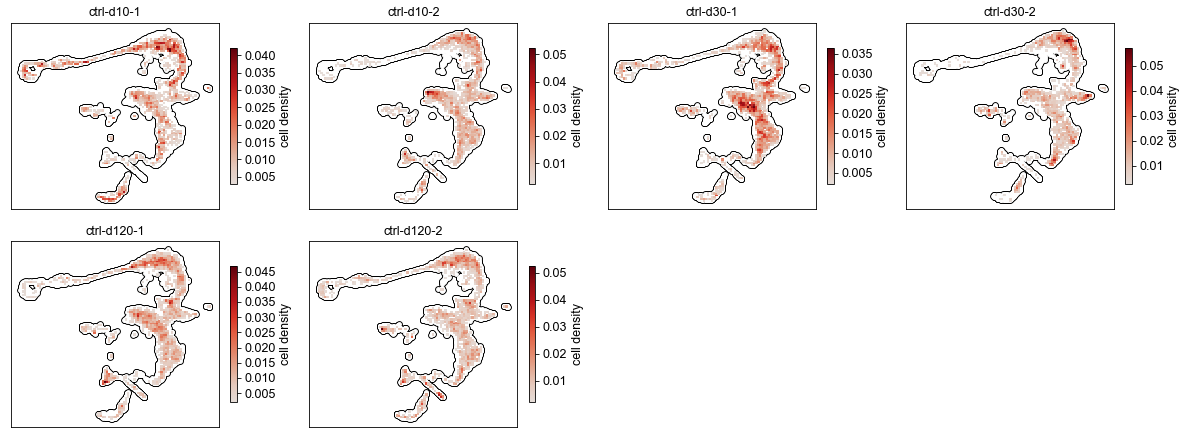

In [95]:
from scipy.ndimage import gaussian_filter
saving = False
fig, nrow, ncol = hf.start_subplot_figure(len(samps_merge), n_columns=4, fig_width=16, row_height=3, dpi=75)

xlims = [x.min() - x.ptp() * 0.05, x.max() + x.ptp() * 0.05]
ylims = [y.min() - y.ptp() * 0.05, y.max() + y.ptp() * 0.05]

n_bins = 100
gauss_width = 0.5

axes = []
plots = []
max_val = 0

for iS,s in enumerate(samps_merge):
    ax = plt.subplot(nrow, ncol, iS+1)
    mask = adata.obs['sample'].values.astype(str) == s
    
    dat, xbins, ybins = np.histogram2d(x[mask], y[mask], bins=[np.linspace(xlims[0], xlims[1], n_bins), np.linspace(ylims[0], ylims[1], n_bins)], density=True)
    dat2 = gaussian_filter(dat, gauss_width, mode='constant')

    dens_x = []
    dens_y = []
    dens_z = []
    for iX in range(len(xbins)-1):
        this_x = (xbins[iX] + xbins[iX+1]) / 2
        for iY in range(len(ybins)-1):
            this_y = (ybins[iY] + ybins[iY+1]) / 2
            this_z = dat[iX, iY]
            if this_z > 0:
                dens_x.append(this_x)
                dens_y.append(this_y)
                dens_z.append(dat2[iX, iY])
    
    #ax.scatter(x, y, s=1, c=.9*np.ones(3))
    ax.scatter(x, y, s=30, c='black')
    ax.scatter(x, y, s=13, c='white')
    dens_x = np.array(dens_x)
    dens_y = np.array(dens_y)
    dens_z = np.array(dens_z)
    pp=ax.scatter(dens_x, dens_y, c=dens_z, s=2, cmap=hf.darken_cmap(plt.cm.Reds, .9), marker='s')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    #ax.imshow(dat2)
    ax.set_title(s,fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    max_val = max(max_val, dens_z.max())
    axes.append(ax)
    plots.append(pp)
    
    

for iP,pp in enumerate(plots):
    #pp.set_clim(0, max_val)
    fig.colorbar(pp, ax=axes[iP], label='cell density', fraction=0.03)
# cbaxes = fig.add_axes([0.99, 0.25, 0.01, 0.5])
# cb = fig.colorbar(pp, cax=cbaxes, label='cell density') 

fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/sample_density.png', dpi=400)

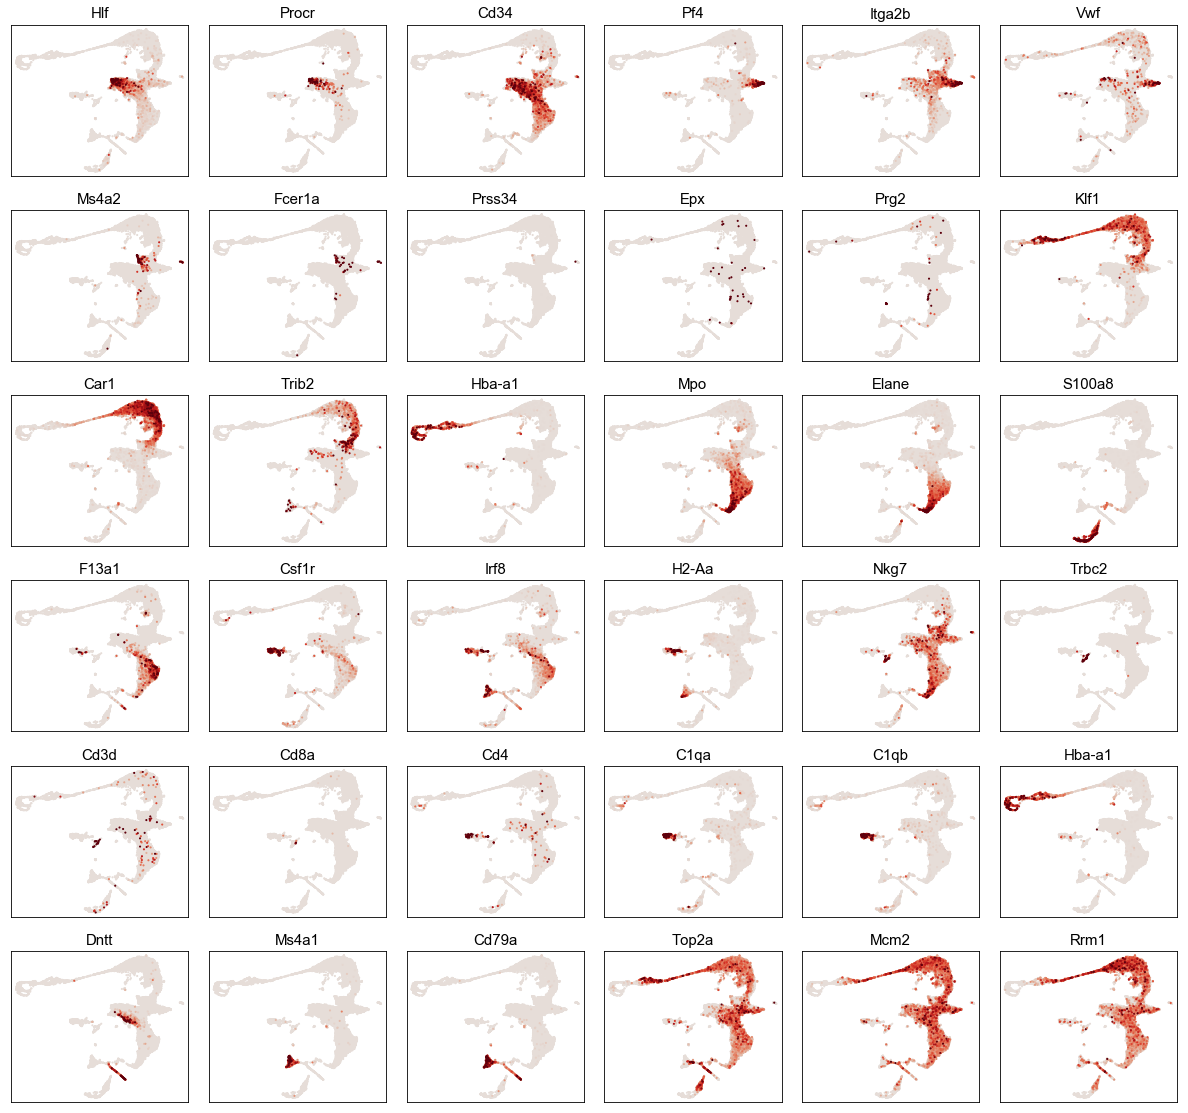

In [96]:
saving = False

# List of genes to plot
genes_plot = ['Hlf', 'Procr', 'Cd34', # stem/progenitor
              'Pf4', 'Itga2b', 'Vwf', # megakaryocyte
              'Ms4a2', 'Fcer1a', 'Prss34', # basophil/mast cell
              'Epx', 'Prg2', # eosinophil
              'Klf1', 'Car1','Trib2', 'Hba-a1', # erythroid progenitor
              'Mpo', 'Elane', 'S100a8', # neutrophil
              'F13a1', 'Csf1r', 'Irf8', # monocyte/macrophage
              'H2-Aa','Nkg7','Trbc2', 'Cd3d', 'Cd8a', 'Cd4',
              'C1qa', 'C1qb', 'Hba-a1', # mature macrophage/erythroblastic island
              'Dntt', 'Ms4a1', 'Cd79a', # lymphoid,
              'Top2a','Mcm2', 'Rrm1'
             ]

# Start figure
fig,nrow,ncol = hf.start_subplot_figure(len(genes_plot), row_height=2.5, n_columns=6, fig_width=16, dpi=75)

# Plot each gene's expression in a different subplot
for iG,g in enumerate(genes_plot):
    ax = plt.subplot(nrow, ncol, iG+1)
    hf.plot_one_gene(adata.X, gene_list, g, x, y, ax=ax, col_range=(0, 99.8), point_size=1)
    ax.set_title(g)
    
fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/marker_genes.png',dpi=150)

## We have a lot of doublets, so re-process without them

In [4]:
print(adata.shape)
adata = adata[~adata.obs['predicted_doublet']]
print(adata.shape)

(15196, 40523)
(14714, 40523)


Finding highly variable genes...


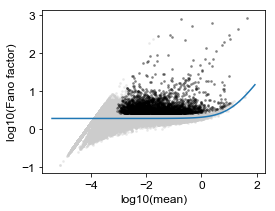

Keeping 2996 genes
Running PCA...
Building kNN graph...
Running Leiden clustering...
Running UMAP...
Done!


In [5]:
# gene filtering parameters
min_counts = 3
min_cells = 3
min_vscore_pctl = 85

# Number of principal components
n_pcs = 40

# Number of neighbors for KNN graph construction
n_neighbors = 10

# UMAP parameters
umap_min_dist = 0.3

print('Finding highly variable genes...')
highvar_genes = gene_list[hf.filter_genes(
    adata.X, 
    min_counts=min_counts, 
    min_cells=min_cells, 
    min_vscore_pctl=min_vscore_pctl, 
    show_vscore_plot=True)]
adata.var['highly_variable'] = False
adata.var.loc[highvar_genes, 'highly_variable'] = True
print(f'Keeping {len(highvar_genes)} genes')


print('Running PCA...')
adata.obsm['X_pca'] = hf.get_pca(adata[:, highvar_genes].X, numpc=n_pcs)

print('Building kNN graph...')
sc.pp.neighbors(adata, n_neighbors=n_neighbors)

print('Running Leiden clustering...')
sc.tl.leiden(adata, resolution=1)

print('Running UMAP...')
sc.tl.umap(adata, min_dist=umap_min_dist)

print('Done!')


## Visualize using 2-D embedding (UMAP)


In [6]:
x = adata.obsm['X_umap'][:,0]
y = adata.obsm['X_umap'][:,1]

#### Check out where each sample's cells lie in the embedding
In each subplot, cells from one sample are colored black, and all others are gray.  
Because this example notebook only includes control cells, they should all mostly overlap.

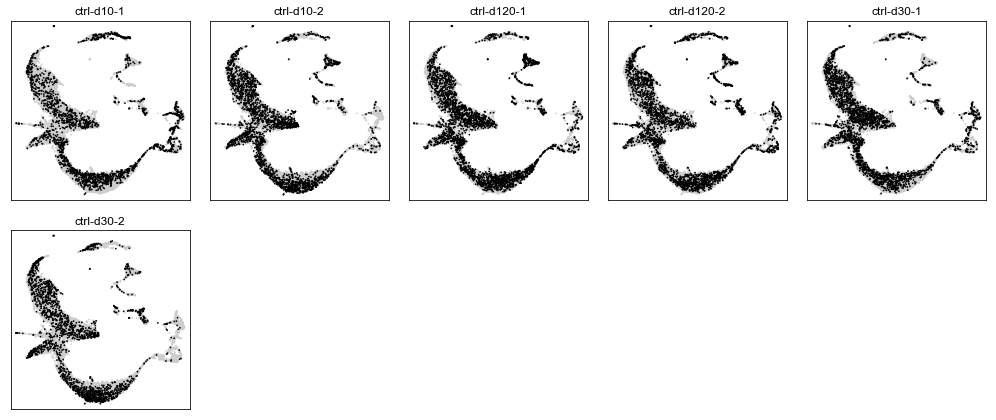

In [7]:
hf.plot_groups(x, y, adata.obs['sample'].values.astype(str))

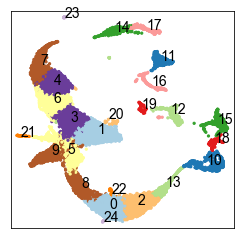

In [8]:
hf.plot_categorical(x, y, adata.obs['leiden'].values, show_centroids=True, centroid_label_size=14)


In [11]:
adata.obs['sample'].cat.categories

Index(['ctrl-d10-1', 'ctrl-d10-2', 'ctrl-d30-1', 'ctrl-d30-2', 'ctrl-d120-1',
       'ctrl-d120-2'],
      dtype='object')

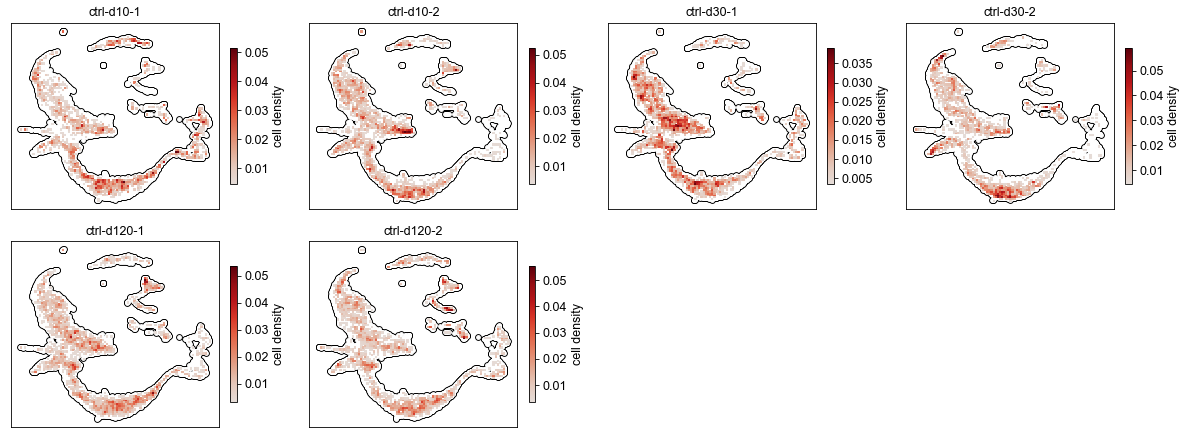

In [20]:
from scipy.ndimage import gaussian_filter
saving = False

plot_variable = 'sample'
plot_values = adata.obs['sample'].cat.categories

fig, nrow, ncol = hf.start_subplot_figure(len(plot_values), n_columns=4, fig_width=16, row_height=3, dpi=75)

xlims = [x.min() - x.ptp() * 0.05, x.max() + x.ptp() * 0.05]
ylims = [y.min() - y.ptp() * 0.05, y.max() + y.ptp() * 0.05]

n_bins = 100
gauss_width = 0.5

axes = []
plots = []
max_val = 0

for iS,s in enumerate(plot_values):
    ax = plt.subplot(nrow, ncol, iS+1)
    mask = adata.obs[plot_variable].eq(s).values
    
    dat, xbins, ybins = np.histogram2d(x[mask], y[mask], bins=[np.linspace(xlims[0], xlims[1], n_bins), np.linspace(ylims[0], ylims[1], n_bins)], density=True)
    dat2 = gaussian_filter(dat, gauss_width, mode='constant')

    dens_x = []
    dens_y = []
    dens_z = []
    for iX in range(len(xbins)-1):
        this_x = (xbins[iX] + xbins[iX+1]) / 2
        for iY in range(len(ybins)-1):
            this_y = (ybins[iY] + ybins[iY+1]) / 2
            this_z = dat[iX, iY]
            if this_z > 0:
                dens_x.append(this_x)
                dens_y.append(this_y)
                dens_z.append(dat2[iX, iY])
    
    #ax.scatter(x, y, s=1, c=.9*np.ones(3))
    ax.scatter(x, y, s=30, c='black')
    ax.scatter(x, y, s=13, c='white')
    dens_x = np.array(dens_x)
    dens_y = np.array(dens_y)
    dens_z = np.array(dens_z)
    pp=ax.scatter(dens_x, dens_y, c=dens_z, s=2, cmap=hf.darken_cmap(plt.cm.Reds, .9), marker='s')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    #ax.imshow(dat2)
    ax.set_title(s,fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    max_val = max(max_val, dens_z.max())
    axes.append(ax)
    plots.append(pp)
    
    

for iP,pp in enumerate(plots):
    #pp.set_clim(0, max_val)
    fig.colorbar(pp, ax=axes[iP], label='cell density', fraction=0.03)
# cbaxes = fig.add_axes([0.99, 0.25, 0.01, 0.5])
# cb = fig.colorbar(pp, cax=cbaxes, label='cell density') 

fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/sample_density.png', dpi=400)

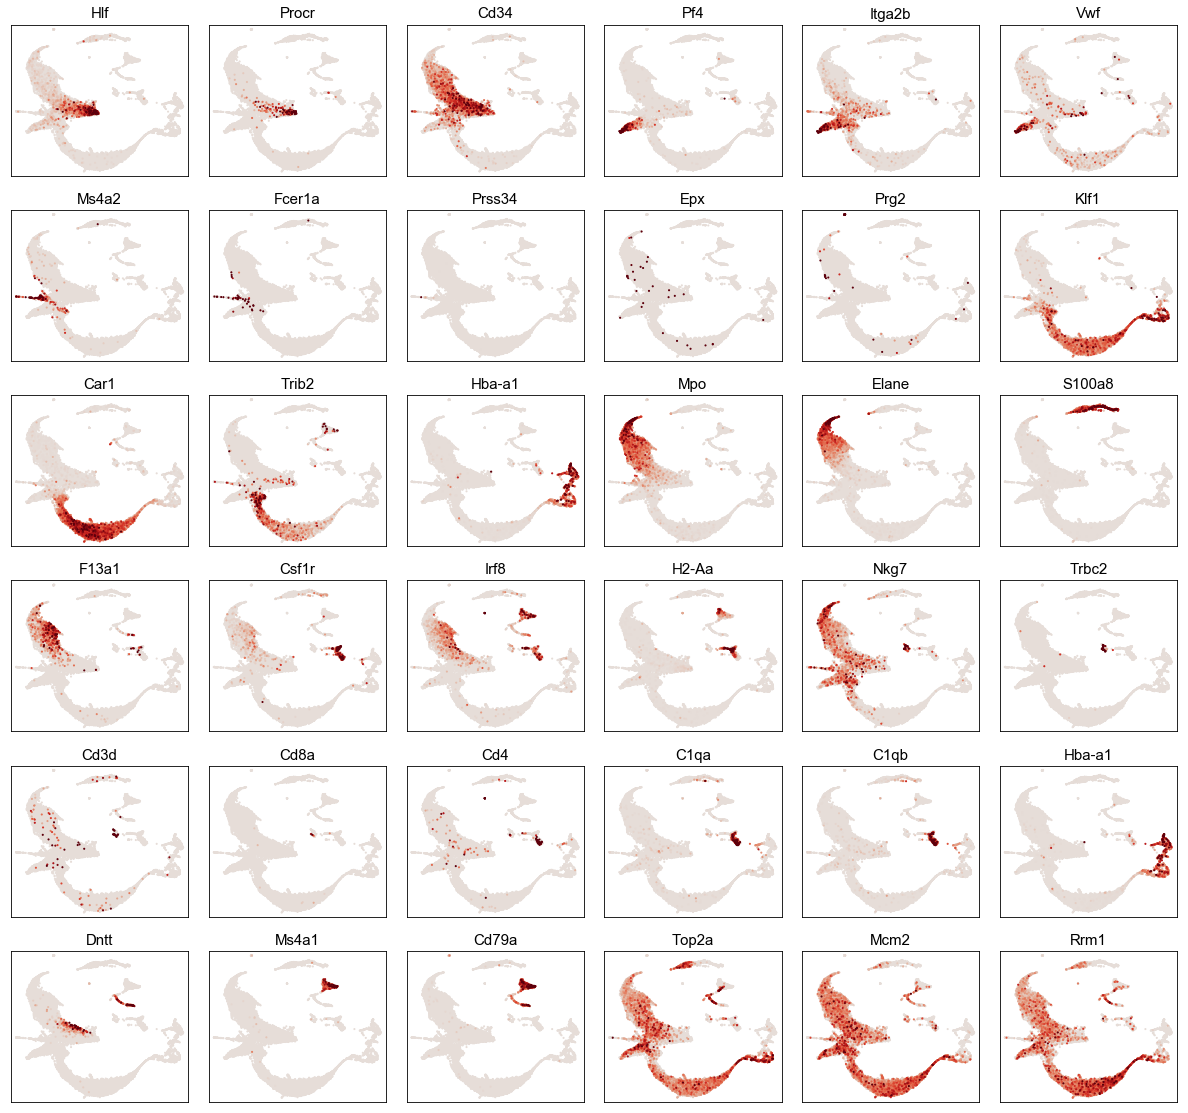

In [21]:
saving = False

# List of genes to plot
genes_plot = ['Hlf', 'Procr', 'Cd34', # stem/progenitor
              'Pf4', 'Itga2b', 'Vwf', # megakaryocyte
              'Ms4a2', 'Fcer1a', 'Prss34', # basophil/mast cell
              'Epx', 'Prg2', # eosinophil
              'Klf1', 'Car1','Trib2', 'Hba-a1', # erythroid progenitor
              'Mpo', 'Elane', 'S100a8', # neutrophil
              'F13a1', 'Csf1r', 'Irf8', # monocyte/macrophage
              'H2-Aa','Nkg7','Trbc2', 'Cd3d', 'Cd8a', 'Cd4',
              'C1qa', 'C1qb', 'Hba-a1', # mature macrophage/erythroblastic island
              'Dntt', 'Ms4a1', 'Cd79a', # lymphoid,
              'Top2a','Mcm2', 'Rrm1'
             ]

# Start figure
fig,nrow,ncol = hf.start_subplot_figure(len(genes_plot), row_height=2.5, n_columns=6, fig_width=16, dpi=75)

# Plot each gene's expression in a different subplot
for iG,g in enumerate(genes_plot):
    ax = plt.subplot(nrow, ncol, iG+1)
    hf.plot_one_gene(adata.X, gene_list, g, x, y, ax=ax, col_range=(0, 99.8), point_size=1)
    ax.set_title(g)
    
fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/marker_genes.png',dpi=150)

In [22]:
adata.obs.head()

,batch,mito_frac,n_counts,sample,timepoint,leiden,doublet_score,predicted_doublet
index,,,,,,,,
bcFTFD-ctrl-d10-1,1,0.077521,13132.0,ctrl-d10-1,10day,0,0.069965,False
bcHCRH-ctrl-d10-1,1,0.069959,6661.0,ctrl-d10-1,10day,0,0.049964,False
bcFPYL-ctrl-d10-1,1,0.086342,5872.0,ctrl-d10-1,10day,0,0.085158,False
bcEIJQ-ctrl-d10-1,1,0.072238,3973.0,ctrl-d10-1,10day,6,0.115238,False
bcHXEI-ctrl-d10-1,1,0.117607,2908.0,ctrl-d10-1,10day,10,0.069965,False


## Save SPRING plot

In [25]:
categorical_vars = ['batch', 'sample', 'timepoint', 'leiden']
for k in categorical_vars:
    adata.obs[k] = pd.Categorical(adata.obs[k])

#### The SPRING export function automatically exports adata.raw.X if it exists, but we want to use normalized counts, not raw.
Let's remove adata.raw (`adata.raw = None`) so that the normalized counts are exported instead.

In [27]:
orig_counts = adata.raw.X.copy()

In [28]:
adata.raw = None

In [29]:
spring_plot_dir = '/Users/sam/Dropbox (HMS)/inDrops_Analysis/SPRING-latest/housekeeping/SPRING_dev/datasets/quick_example'
sc.external.exporting.spring_project(
    adata, 
    project_dir=spring_plot_dir, 
    subplot_name='all_cells',
    embedding_method='umap',
    cell_groupings=categorical_vars,
    custom_color_tracks=['mito_frac', 'n_counts', 'doublet_score'],
    overwrite=True
)

Writing subplot to /Users/sam/Dropbox (HMS)/inDrops_Analysis/SPRING-latest/housekeeping/SPRING_dev/datasets/quick_example/all_cells/
